In [1]:
from gluefactory.utils.experiments import load_experiment
from torchvision.transforms import Resize
from gluefactory.datasets.homographies import sample_homography
from gluefactory.models.lines.deeplsd import DeepLSD
from gluefactory.models.extractors.superpoint_open import SuperPoint
from gluefactory.models.extractors.jpldd.joint_point_line_extractor import JointPointLineDetectorDescriptor
from gluefactory.models.extractors.aliked import ALIKED
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import flow_vis
import os
import h5py
import kornia.feature as KF
import torchvision

In [2]:
def get_flow_vis(df, ang, line_neighborhood=5):
    norm = line_neighborhood + 1 - np.clip(df, 0, line_neighborhood)
    flow_uv = np.stack([norm * np.cos(ang), norm * np.sin(ang)], axis=-1)
    flow_img = flow_vis.flow_to_color(flow_uv, convert_to_bgr=False)
    return flow_img

def numpy_image_to_torch(image):
    """Normalize the image tensor and reorder the dimensions."""
    if image.ndim == 3:
        image = image.transpose((2, 0, 1))  # HxWxC to CxHxW
    elif image.ndim == 2:
        image = image[None]  # add channel axis
    else:
        raise ValueError(f"Not an image: {image.shape}")
    return torch.tensor(image / 255.0, dtype=torch.float)

In [3]:
model_conf = {
    "name": "jpldd.joint_point_line_extractor",
    #"model_name": "aliked-n16",
    "max_num_keypoints": 500,  # setting for training, for eval: -1
    #"pretrained": True,
    "timeit": True,  # override timeit: False from BaseModel
    #"train_descriptors": {
    #    "do": False,  # if train is True, initialize ALIKED Light model form OTF Descriptor GT
    #    "device": None # device to house the lightweight ALIKED model
    #},
    "line_detection": {
        "do": True
    },
    "checkpoint": None
}
jpldd_model = load_experiment("../rk_jpldd_04/checkpoint_best.tar",model_conf)
#jpldd_model = JointPointLineDetectorDescriptor({})

[05/21/2024 10:00:33 gluefactory.utils.experiments INFO] Loading checkpoint checkpoint_best.tar
Load pretrained weights for aliked parts...


In [10]:
conf_lines = {
    "min_length": 15,
    "max_num_lines": None,
    "force_num_lines": False,
    "model_conf": {
        "detect_lines": True,
        "line_detection_params": {
            "merge": False,
            "grad_nfa": True,
            "filtering": "normal",
            "grad_thresh": 3.0,
        },
    }
}

conf_homography = {
    "difficulty": 0.4,
    "translation": 0.6,
    "max_angle": 60,
    "n_angles": 10,
    "patch_shape": [640, 480],
    "min_convexity": 0.05,
}

aliked_conf = {
        "model_name": "aliked-n16",
        "max_num_keypoints": 500,
        "detection_threshold": 0.2,
        "force_num_keypoints": False,
        "pretrained": True,
        "nms_radius": 2,
    }

sp_conf = {
    "max_num_keypoints": 500,
    "nms_radius": 4,
    "detection_threshold": 0.005,
    "remove_borders": 4,
    "descriptor_dim": 256,
    "channels": [64, 64, 128, 128, 256],
    "dense_outputs": None,
    "weights": None,  # local path of pretrained weights
}

size = (800,800)



#warped_img = warped_img.unsqueeze(0)

deeplsd_model = DeepLSD(conf_lines)
superpoint_model = SuperPoint(sp_conf)
sold2 = KF.SOLD2(pretrained=True, config=None)
aliked_model = ALIKED(aliked_conf)
deeplsd_model.eval()
resize_func = Resize(size)
image_path = "../data/minidepth/images/0005/562094050_5938f37ea5_o.jpg"
#image_path = "../data/mini_depth_100/00283.jpg"
img = cv2.resize(cv2.imread(image_path),size)
#homography =  sample_homography(img,conf_homography,size)
#img = homography["image"]
#warped_img = numpy_image_to_torch(warped_img)
img_torch = numpy_image_to_torch(img)
img_torch_grayscale = torchvision.transforms.Grayscale()(img_torch).unsqueeze(0)
img_torch = img_torch.unsqueeze(0)
with torch.no_grad():
    output_superpoint = superpoint_model({"image": img_torch})
    output_jpldd = jpldd_model({"image": img_torch})
    output_deeplsd = deeplsd_model.forward_ha({"image": img_torch})
    output_sold2 = sold2(img_torch_grayscale)
    output_aliked = aliked_model({"image": img_torch})
distance_field_jpldd = output_jpldd["line_distancefield"][0]
#distance_field_jpldd = output_jpldd["deeplsd_line_distancefield"][0]
angle_field_jpldd = output_jpldd["line_anglefield"][0]
distance_field_deeplsd = output_deeplsd["df"][0]
angle_field_deeplsd = output_deeplsd["line_level"][0]


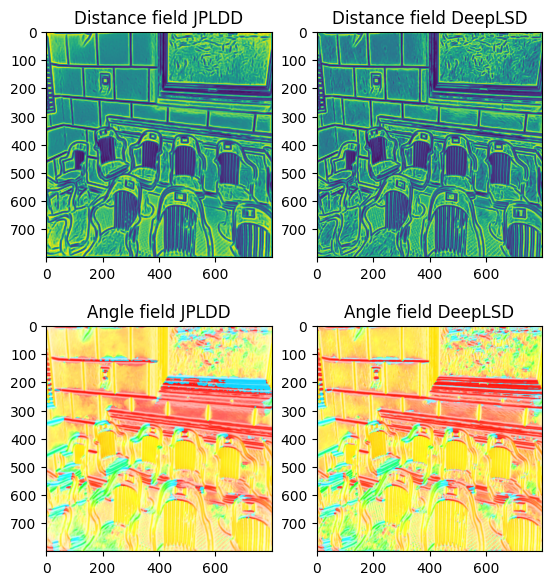

(-0.5, 799.5, 799.5, -0.5)

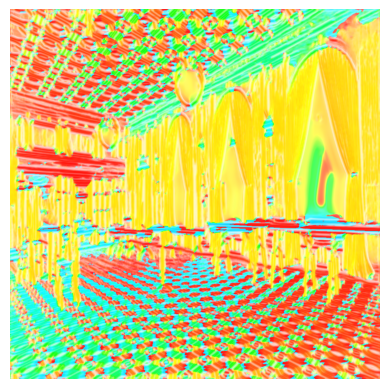

In [31]:
# f, axarr = plt.subplots(2,2) 
plt.imshow(get_flow_vis(distance_field_deeplsd,angle_field_deeplsd))
plt.axis("off")
# use the created array to output your multiple images. In this case I have stacked 4 images vertically
# axarr[0][0].imshow(distance_field_jpldd)
# axarr[0][0].axis("off")
# axarr[0][0].set_title("Distance field JPLDD")
# axarr[1][0].imshow(get_flow_vis(distance_field_jpldd,angle_field_jpldd))
# axarr[1][0].axis("off")
# axarr[1][0].set_title("Angle field JPLDD")
# axarr[0][1].imshow(distance_field_deeplsd)
# axarr[0][1].set_title("Distance field DeepLSD")
# axarr[0][1].axis("off")
# axarr[1][1].imshow(get_flow_vis(distance_field_deeplsd,angle_field_deeplsd))
# axarr[1][1].set_title("Angle field DeepLSD")
# axarr[1][1].axis("off")
# f.set_figheight(6)

In [25]:
output_superpoint["heatmap"][0].max()

tensor(0.9991)

(-0.5, 799.5, 799.5, -0.5)

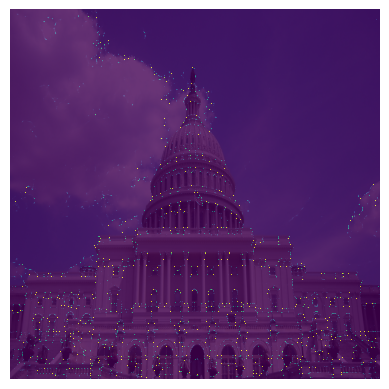

In [18]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#plt.imshow(distance_field_deeplsd)
#plt.imshow(get_flow_vis(distance_field_deeplsd,angle_field_deeplsd))
plt.imshow(output_superpoint["heatmap"][0],interpolation="nearest",vmin=0,vmax=0.2,cmap="viridis",alpha=0.8)
plt.axis('off')
# plt.show()

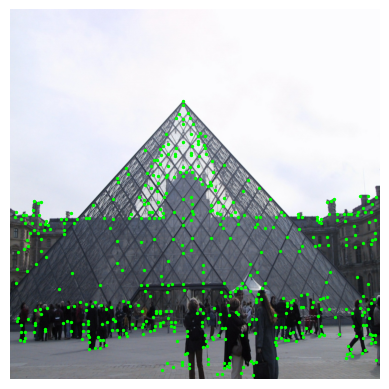

In [86]:
#lines = output_sold2["line_segments"]
#lines = output_deeplsd["lines"]
keypoints = output_superpoint["keypoints"][0].T
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#for line in lines[0]:
#   plt.plot(line[:, 1], line[:, 0], c='lime')
plt.scatter(keypoints[0],keypoints[1],s=2,c="lime")
plt.axis("off")
plt.show()

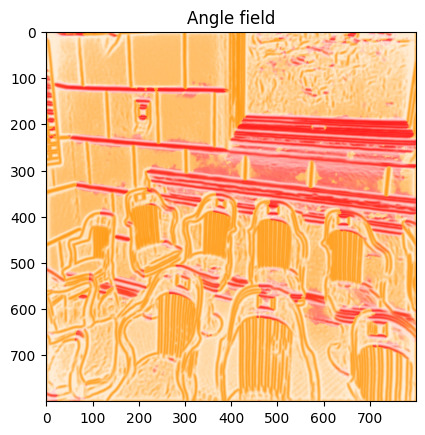

In [17]:
plt.title("Angle field")

plt.imshow(get_flow_vis(distance_field_jpldd,angle_field_jpldd))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Text(0.5, 1.0, 'ALIKED Heatmap')

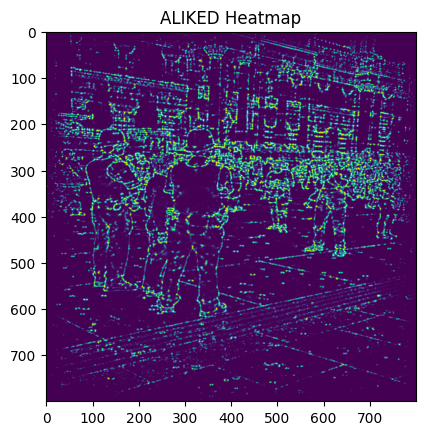

In [13]:
plt.imshow(kp_junction_map)
plt.title("ALIKED Heatmap")

Text(0.5, 1.0, 'JPLDD Keypoint and Junction Heatmap')

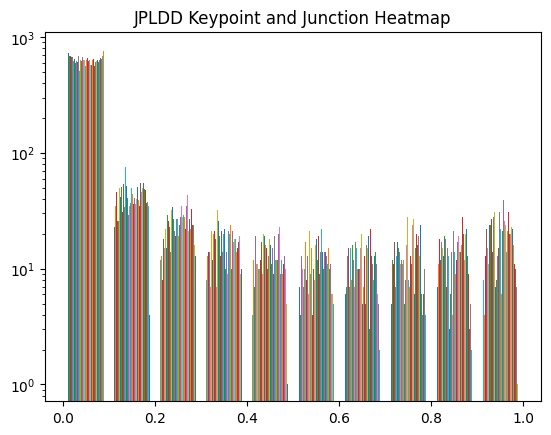

In [42]:
plt.hist(kp_junction_map.numpy())
plt.yscale("log")
plt.title("JPLDD Keypoint and Junction Heatmap")

In [47]:
output_jpldd["keypoints"].shape

torch.Size([1, 1000, 2])

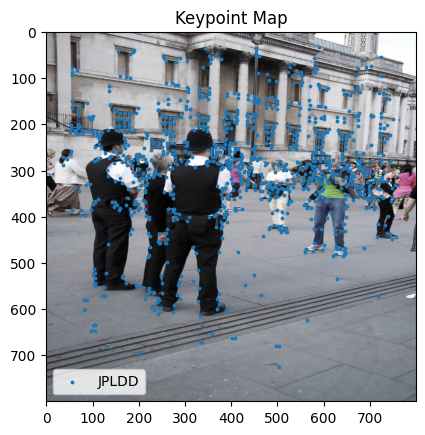

In [12]:
kp_junction_map = output_jpldd["keypoint_and_junction_score_map"][0]
jpldd_keypoints = output_jpldd["keypoints"][0].t()
superpoint_points = output_superpoint["keypoints"][0].t()
superpoint_map = output_superpoint["raw_scores"][0]
flat_indices = np.argpartition(kp_junction_map,-300,axis=None)[-300:]
mask = np.unravel_index(flat_indices,kp_junction_map.shape,order="F")
probs = kp_junction_map[mask]
pred = np.array(mask)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Keypoint Map")
#plt.scatter(superpoint_points[0],superpoint_points[1],s=3,label="Superpoint")
plt.scatter(jpldd_keypoints[0],jpldd_keypoints[1],s=3,label="JPLDD")
plt.legend()
plt.show()

In [43]:
sp_heatmap = output_superpoint["dense_descriptors"]

<KeysViewHDF5 ['deeplsd_angle_field', 'deeplsd_distance_field']>


(-0.5, 799.5, 799.5, -0.5)

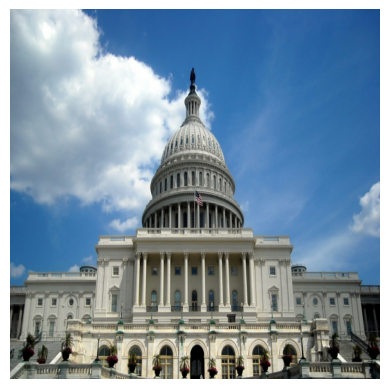

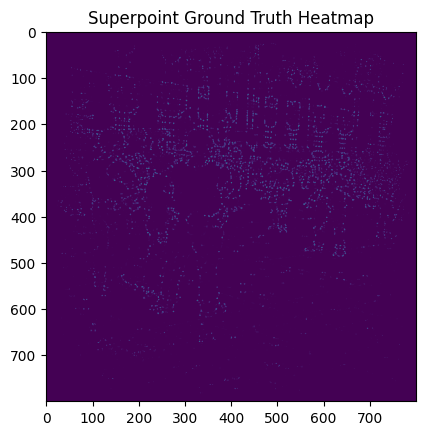

In [21]:
with h5py.File("../capitol_deeplsd.hdf5", 'r') as f:
        print(f.keys())
        angle_field = np.array(f['deeplsd_angle_field'])
        distance_field = np.array(f['deeplsd_distance_field'])
plt.axis("off")
#plt.title("Superpoint Ground Truth Heatmap")